**Thinkful - 4.2.5 - Challenge - Boston Marathon (Clustering)**

Use the tools at hand to:
* Determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. 
* Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. 
* Write up your report, including your process from start to finish, in a Jupyter notebook and submit it.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
from itertools import cycle

%matplotlib inline

In [2]:
df = pd.read_csv("Data/Boston Marathon.csv",encoding='latin1')

print(len(df))
df.head()

8367


,name,country,ctz,state,city,bib,gender,overall,division,genderdiv,...,5k,10k,20k,half,25k,30k,35k,40k,official,flag
0,"Van Dyk, Ernst F.",RSA,NaN,NaN,Paarl,W2,M,1.0,1,1,...,7.75,16.62,36.10,38.03,45.80,56.45,67.42,76.10,80.60,NaN
1,"Keflezighi, Meb",USA,NaN,CA,San Diego,19,M,1.0,1,1,...,15.15,30.48,61.08,64.35,76.00,91.17,106.62,121.82,128.62,NaN
2,"Hokinoue, Kota",JPN,NaN,NaN,Nogata Fukuoka,W3,M,2.0,2,2,...,8.02,17.12,36.58,38.60,46.37,57.03,67.83,76.72,81.23,NaN
3,"Chebet, Wilson",KEN,NaN,NaN,Marakwet,7,M,2.0,2,2,...,15.18,30.52,61.63,64.87,76.97,92.52,107.47,121.95,128.80,NaN
4,"Soejima, Masazumi",JPN,NaN,NaN,Isahaya,W6,M,3.0,3,3,...,8.00,17.12,36.60,38.60,46.37,57.03,67.83,76.70,81.23,NaN


**Data Cleaning and Feature Engineering**

In [3]:
df.shape

(8367, 22)

In [4]:
df.isnull().sum()

name            0
country         1
ctz          7914
state         915
city            1
bib             0
gender          0
overall         1
division        0
genderdiv       0
age             0
pace            1
5k              1
10k             0
20k             1
half            1
25k             0
30k             1
35k             1
40k             1
official        0
flag         8366
dtype: int64

In [5]:
# Drop columns missing vast amounts of data
df = df.drop(['name','ctz','state','flag','city'],axis=1)

# Remove rows with hyphens and null values
df = df[~((df['5k'] == '-' ) | (df['10k'] == '-' ) | (df['20k'] == '-' ) | (df['half'] == '-' ) | 
            (df['25k'] == '-' )| (df['30k'] == '-' ) | (df['35k'] == '-' ) | (df['40k'] == '-' ))]

# Drop null values
#df = df.dropna()
#df.drop([2731],axis = 'index')

#Rearrange columns
df = df[['country','bib','gender','overall','division','genderdiv','age','pace','5k','10k',
         '20k','half','25k','30k','35k','40k','official']]

print(df.shape)
df.isnull().sum()

(8345, 17)


country      1
bib          0
gender       0
overall      1
division     0
genderdiv    0
age          0
pace         1
5k           1
10k          0
20k          1
half         1
25k          0
30k          1
35k          1
40k          1
official     0
dtype: int64

In [6]:
# Drop null values
df.dropna(inplace=True)
#df.drop([2731],axis = 'index')
print(df.shape)

(8344, 17)


In [7]:
df.dtypes

country       object
bib           object
gender        object
overall      float64
division       int64
genderdiv      int64
age            int64
pace         float64
5k            object
10k           object
20k           object
half          object
25k           object
30k           object
35k           object
40k           object
official     float64
dtype: object

In [8]:
# Convert numerical variables
df[['5k','10k','20k','half','25k','30k','35k','40k']] = df[['5k','10k','20k','half','25k','30k','35k',
                                                            '40k']].apply(pd.to_numeric, errors='coerce')

print(df.dtypes)
df.head()

country       object
bib           object
gender        object
overall      float64
division       int64
genderdiv      int64
age            int64
pace         float64
5k           float64
10k          float64
20k          float64
half         float64
25k          float64
30k          float64
35k          float64
40k          float64
official     float64
dtype: object


,country,bib,gender,overall,division,genderdiv,age,pace,5k,10k,20k,half,25k,30k,35k,40k,official
0,RSA,W2,M,1.0,1,1,41,3.08,7.75,16.62,36.10,38.03,45.80,56.45,67.42,76.10,80.60
1,USA,19,M,1.0,1,1,38,4.92,15.15,30.48,61.08,64.35,76.00,91.17,106.62,121.82,128.62
2,JPN,W3,M,2.0,2,2,40,3.10,8.02,17.12,36.58,38.60,46.37,57.03,67.83,76.72,81.23
3,KEN,7,M,2.0,2,2,28,4.92,15.18,30.52,61.63,64.87,76.97,92.52,107.47,121.95,128.80
4,JPN,W6,M,3.0,3,3,43,3.10,8.00,17.12,36.60,38.60,46.37,57.03,67.83,76.70,81.23


In [9]:
'''# Create category for wheelchair users and visually impaired
wheelchair = []
vis_imp = []
bib = df['bib']
for i in range(len(bib)):
    if (re.search('W' , bib[i])):
        wheelchair.append(1)
        vis_imp.append(0)
    elif (re.search('F' , bib[i])):
        wheelchair.append(0)
        vis_imp.append(1)
    else:
        wheelchair.append(0)
        vis_imp.append(0)

df['Wheelchair'] = pd.Series(wheelchair, index=df.index)
df['Visually Impaired'] = pd.Series(vis_imp, index=df.index)'''

# Convert categories to integers
df['gender']= df['gender'].apply(lambda x: 1 if x == 'M' else 0)
df['country']= df['country'].apply(lambda x: 1 if x == 'USA' else 0)

df = df.drop(['bib'],axis=1)
print(df.shape)

df.head(5)

(8344, 16)


,country,gender,overall,division,genderdiv,age,pace,5k,10k,20k,half,25k,30k,35k,40k,official
0,0,1,1.0,1,1,41,3.08,7.75,16.62,36.10,38.03,45.80,56.45,67.42,76.10,80.60
1,1,1,1.0,1,1,38,4.92,15.15,30.48,61.08,64.35,76.00,91.17,106.62,121.82,128.62
2,0,1,2.0,2,2,40,3.10,8.02,17.12,36.58,38.60,46.37,57.03,67.83,76.72,81.23
3,0,1,2.0,2,2,28,4.92,15.18,30.52,61.63,64.87,76.97,92.52,107.47,121.95,128.80
4,0,1,3.0,3,3,43,3.10,8.00,17.12,36.60,38.60,46.37,57.03,67.83,76.70,81.23


**Cluster Exploration**

I attempted to model two different outcome variables: gender (male vs. female) and nationality (USA vs. non-USA). 

For both models, I plotted the data using K-means, minibatch K-means, and mean shifting. The clustering was not ideal. For example, for the gender prediction models, we can visually see that there is a clear trend for males vs. females when plotting division placement vs. overall time, however, rather than clustering based on gender, all three models segmented both lines and clustered based on time. Ideally, there wouldn't be any shared colors between both trendlines. Although the outcome clustering was not ideal, it makes sense for these three models, as they tend to cluster based on proximity.

A spectral clustering model may have been able to more accurately cluster the data, since it tends to cluster based on how similar two points are, however, when I attempted to model using spectral clustering the model was taking excessive time to run (in the realm of hours) without outputting any results and therefore I abandoned those efforts. I experienced a similar result when attempting affinity propogation.

In [10]:
X = df.drop(['gender'],axis=1)
y = df['gender']

K-MEANS
Comparing k-means clusters against the data:
gender    0     1
row_0            
0       488  3178
1        88  1268
2       289  2652
3        20   361
Rand Score =  -0.0148666470671


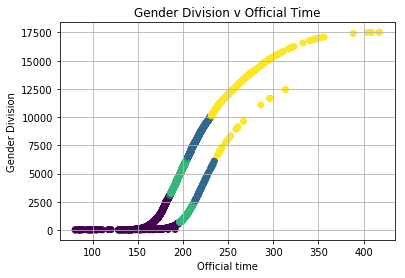

In [11]:
print("K-MEANS")
# Calculate predicted values.
y_pred = KMeans(n_clusters=4).fit_predict(X)

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))
print("Rand Score = ",metrics.adjusted_rand_score(y, y_pred))

# Plot the solution.
plt.scatter(x = df['official'], y = df['genderdiv'], c = y_pred)
plt.xlabel('Official time')
plt.ylabel('Gender Division')
plt.title('Gender Division v Official Time')
plt.grid(True)
plt.show()


Minibatch K-MEANS
Comparing k-means clusters against the data:
gender    0     1
row_0            
0       150  1996
1        51   862
2       384  2310
3       300  2291
Rand Score =  -0.00702647943473


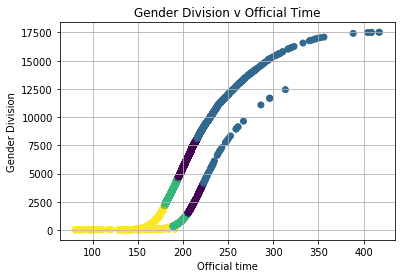

In [12]:
print("\nMinibatch K-MEANS")
# Calculate predicted values.
minibatchkmeans = MiniBatchKMeans(init='random',n_clusters=4,batch_size=200)
minibatchkmeans.fit(X)
predict_mini = minibatchkmeans.predict(X)

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(predict_mini,y))
print("Rand Score = ",metrics.adjusted_rand_score(y, predict_mini))

# Plot the solution.
plt.scatter(x = df['official'], y = df['genderdiv'], c = predict_mini)
plt.xlabel('Official time')
plt.ylabel('Gender Division')
plt.title('Gender Division v Official Time')
plt.grid(True)
plt.show()


MEAN SHIFT
Number of estimated clusters: 3
Comparing k-means clusters against the data:
gender    0     1
row_0            
0       807  6420
1        74   931
2         4   108
Rand Score =  -0.0344770186782


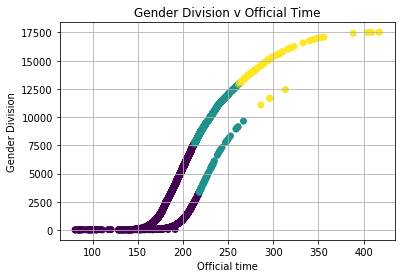

In [13]:
print("\nMEAN SHIFT")

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(labels, y))
print("Rand Score = ",metrics.adjusted_rand_score(y, labels))

plt.scatter(x = df['official'], y = df['genderdiv'], c = labels)
plt.xlabel('Official time')
plt.ylabel('Gender Division')
plt.title('Gender Division v Official Time')
plt.grid(True)
plt.show()

**USA vs. Non-USA**

Again, the clustering for this model was not ideal, however, I wouldn't expect to see any significant clustering based on nationality with only two groups (USA vs. Non-USA). We can visually see that there is a clear trend for each division, but the all three models segmented the trendlines lines and clustered based on time/division ranking. Although the outcome clustering was not ideal, it makes sense for these three models, as they tend to cluster based on proximity.

In [38]:
X = df.drop(['country'],axis=1)
y = df['country']

K-MEANS
Comparing k-means clusters against the data:
country    0     1
row_0             
0        563  2231
1        846  3978
2        132   594
Rand Score =  0.00646592851258


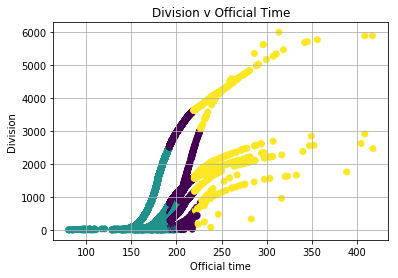

In [34]:
print("K-MEANS")
# Calculate predicted values.
y_pred = KMeans(n_clusters=3).fit_predict(X)

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))
print("Rand Score = ",metrics.adjusted_rand_score(y, y_pred))

# Plot the solution.
plt.scatter(x = df['official'], y = df['division'], c = y_pred)
plt.xlabel('Official time')
plt.ylabel('Division')
plt.title('Division v Official Time')
plt.grid(True)
plt.show()


Minibatch K-MEANS
Comparing k-means clusters against the data:
country    0     1
row_0             
0        512  2046
1        883  4104
2        146   653
Rand Score =  0.00655472871172


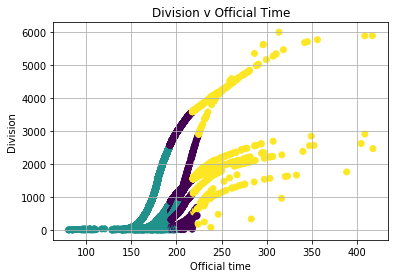

In [36]:
print("\nMinibatch K-MEANS")
# Calculate predicted values.
minibatchkmeans = MiniBatchKMeans(init='random',n_clusters=3,batch_size=200)
minibatchkmeans.fit(X)
predict_mini = minibatchkmeans.predict(X)

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(predict_mini,y))
print("Rand Score = ",metrics.adjusted_rand_score(y, predict_mini))

# Plot the solution.
plt.scatter(x = df['official'], y = df['division'], c = predict_mini)
plt.xlabel('Official time')
plt.ylabel('Division')
plt.title('Division v Official Time')
plt.grid(True)
plt.show()


MEAN SHIFT
Number of estimated clusters: 3
Comparing k-means clusters against the data:
country     0     1
row_0              
0        1332  5895
1         189   816
2          20    92
Rand Score =  0.00145080614185


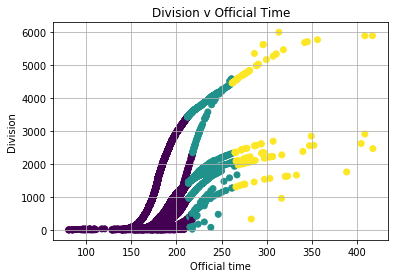

In [37]:
print("\nMEAN SHIFT")

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(labels, y))
print("Rand Score = ",metrics.adjusted_rand_score(y, labels))

plt.scatter(x = df['official'], y = df['division'], c = labels)
plt.xlabel('Official time')
plt.ylabel('Division')
plt.title('Division v Official Time')
plt.grid(True)
plt.show()

After plotting this data and attempting to find clusters, I discovered that:
* More men compete in the Boston marathon than women.
* Overall, men are faster runners than women (for a man and woman who finished at the same place in their division, the man had a time which was about 25 minutes faster than the woman's), which was expected, however, the slowest runners are also men, which was unexpected.
* Different models are more appropriate for clustering different types of data.